In [117]:
def get_grid_locations(image_height, image_width):
    """Wrapper for np.meshgrid."""

    y_range = np.linspace(0, image_height - 1, image_height)
    x_range = np.linspace(0, image_width - 1, image_width)
    y_grid, x_grid = np.meshgrid(y_range, x_range, indexing='ij')
    return np.stack((y_grid, x_grid), -1)

def flatten_grid_locations(grid_locations, image_height, image_width):
    return np.reshape(grid_locations, [image_height * image_width, 2])

def interpolate_spline(train_points, train_values, query_points, order, regularization_weight=0.0, ):
    # First, fit the spline to the observed data.
    w, v = solve_interpolation(train_points,train_values, order, regularization_weight)
    # Then, evaluate the spline at the query locations.
    query_values = apply_interpolation(query_points, train_points, w, v, order)

    return query_values



In [133]:
def solve_interpolation(train_points, train_values, order, regularization_weight):
    b, n, d = train_points.shape
    k = train_values.shape[-1]

    # First, rename variables so that the notation (c, f, w, v, A, B, etc.)
    # follows https://en.wikipedia.org/wiki/Polyharmonic_spline.
    # To account for python style guidelines we use
    # matrix_a for A and matrix_b for B.

    c = train_points
    f = train_values.float()

    matrix_a = phi(cross_squared_distance_matrix(c, c), order).unsqueeze(0)  # [b, n, n]
    #     if regularization_weight > 0:
    #         batch_identity_matrix = array_ops.expand_dims(
    #           linalg_ops.eye(n, dtype=c.dtype), 0)
    #         matrix_a += regularization_weight * batch_identity_matrix

    # Append ones to the feature values for the bias term in the linear model.
    ones = torch.ones(1, dtype=train_points.dtype).view([-1, 1, 1])
    matrix_b = torch.cat((c, ones), 2).float()  # [b, n, d + 1]

    # [b, n + d + 1, n]
    left_block = torch.cat((matrix_a, torch.transpose(matrix_b, 2, 1)), 1)

    num_b_cols = matrix_b.shape[2]  # d + 1

    # In Tensorflow, zeros are used here. Pytorch gesv fails with zeros for some reason we don't understand.
    # So instead we use very tiny randn values (variance of one, zero mean) on one side of our multiplication.
    lhs_zeros = torch.randn((b, num_b_cols, num_b_cols)) / 1e10
    right_block = torch.cat((matrix_b, lhs_zeros),
                            1)  # [b, n + d + 1, d + 1]
    lhs = torch.cat((left_block, right_block),
                    2)  # [b, n + d + 1, n + d + 1]

    rhs_zeros = torch.zeros((b, d + 1, k), dtype=train_points.dtype).float()
    rhs = torch.cat((f, rhs_zeros), 1)  # [b, n + d + 1, k]

    # Then, solve the linear system and unpack the results.
    X, LU = torch.linalg.solve(rhs, lhs)
    w = X[:, :n, :]
    v = X[:, n:, :]

    return w, v


In [106]:
def cross_squared_distance_matrix(x, y):
    """Pairwise squared distance between two (batch) matrices' rows (2nd dim).
        Computes the pairwise distances between rows of x and rows of y
        Args:
        x: [batch_size, n, d] float `Tensor`
        y: [batch_size, m, d] float `Tensor`
        Returns:
        squared_dists: [batch_size, n, m] float `Tensor`, where
        squared_dists[b,i,j] = ||x[b,i,:] - y[b,j,:]||^2
    """
    x_norm_squared = torch.sum(torch.mul(x, x))
    y_norm_squared = torch.sum(torch.mul(y, y))

    x_y_transpose = torch.matmul(x.squeeze(0), y.squeeze(0).transpose(0, 1))

    # squared_dists[b,i,j] = ||x_bi - y_bj||^2 = x_bi'x_bi- 2x_bi'x_bj + x_bj'x_bj
    squared_dists = x_norm_squared - 2 * x_y_transpose + y_norm_squared

    return squared_dists.float()


In [107]:
def phi(r, order):
    """Coordinate-wise nonlinearity used to define the order of the interpolation.
    See https://en.wikipedia.org/wiki/Polyharmonic_spline for the definition.
    Args:
    r: input op
    order: interpolation order
    Returns:
    phi_k evaluated coordinate-wise on r, for k = r
    """
    EPSILON = torch.tensor(1e-10)
    # using EPSILON prevents log(0), sqrt0), etc.
    # sqrt(0) is well-defined, but its gradient is not
    if order == 1:
        r = torch.max(r, EPSILON)
        r = torch.sqrt(r)
        return r
    elif order == 2:
        return 0.5 * r * torch.log(torch.max(r, EPSILON))
    elif order == 4:
        return 0.5 * torch.square(r) * torch.log(torch.max(r, EPSILON))
    elif order % 2 == 0:
        r = torch.max(r, EPSILON)
        return 0.5 * torch.pow(r, 0.5 * order) * torch.log(r)
    else:
        r = torch.max(r, EPSILON)
        return torch.pow(r, 0.5 * order)

# SpecAugment

In [109]:
import librosa
import librosa.display
import numpy as np
import random
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import torch

In [110]:
def sparse_image_warp(img_tensor,
                      source_control_point_locations,
                      dest_control_point_locations,
                      interpolation_order=2,
                      regularization_weight=0.0,
                      num_boundaries_points=0):
    control_point_flows = (dest_control_point_locations - source_control_point_locations)

    batch_size, image_height, image_width = img_tensor.shape
    grid_locations = get_grid_locations(image_height, image_width)
    flattened_grid_locations = torch.tensor(flatten_grid_locations(grid_locations, image_height, image_width))

    flattened_flows = interpolate_spline(
        dest_control_point_locations,
        control_point_flows,
        flattened_grid_locations,
        interpolation_order,
        regularization_weight)

    dense_flows = create_dense_flows(flattened_flows, batch_size, image_height, image_width)

    warped_image = dense_image_warp(img_tensor, dense_flows)

    return warped_image, dense_flows

In [111]:
def time_warp(spec, W=5):
    num_rows = spec.shape[1]
    spec_len = spec.shape[2]

    y = num_rows // 2
    horizontal_line_at_ctr = spec[0][y]
    # assert len(horizontal_line_at_ctr) == spec_len

    point_to_warp = horizontal_line_at_ctr[random.randrange(W, spec_len-W)]
    # assert isinstance(point_to_warp, torch.Tensor)

    # Uniform distribution from (0,W) with chance to be up to W negative
    dist_to_warp = random.randrange(-W, W)
    src_pts = torch.tensor([[[y, point_to_warp]]])
    dest_pts = torch.tensor([[[y, point_to_warp + dist_to_warp]]])
    warped_spectro, dense_flows = sparse_image_warp(spec, src_pts, dest_pts)
    return warped_spectro.squeeze(3)


In [112]:
def spec_augment(mel_spectrogram, time_warping_para=80, frequency_masking_para=27,
                 time_masking_para=100, frequency_mask_num=1, time_mask_num=1):
    """Spec augmentation Calculation Function.
    'SpecAugment' have 3 steps for audio data augmentation.
    first step is time warping using Tensorflow's image_sparse_warp function.
    Second step is frequency masking, last step is time masking.
    # Arguments:
      mel_spectrogram(numpy array): audio file path of you want to warping and masking.
      time_warping_para(float): Augmentation parameter, "time warp parameter W".
        If none, default = 80 for LibriSpeech.
      frequency_masking_para(float): Augmentation parameter, "frequency mask parameter F"
        If none, default = 100 for LibriSpeech.
      time_masking_para(float): Augmentation parameter, "time mask parameter T"
        If none, default = 27 for LibriSpeech.
      frequency_mask_num(float): number of frequency masking lines, "m_F".
        If none, default = 1 for LibriSpeech.
      time_mask_num(float): number of time masking lines, "m_T".
        If none, default = 1 for LibriSpeech.
    # Returns
      mel_spectrogram(numpy array): warped and masked mel spectrogram.
    """
    v = mel_spectrogram.shape[1]
    tau = mel_spectrogram.shape[2]

    # Step 1 : Time warping
    warped_mel_spectrogram = time_warp(mel_spectrogram, W=time_warping_para)

    # Step 2 : Frequency masking
    for i in range(frequency_mask_num):
        f = np.random.uniform(low=0.0, high=frequency_masking_para)
        f = int(f)
        f0 = random.randint(0, v-f)
        warped_mel_spectrogram[:, f0:f0+f, :] = 0

    # Step 3 : Time masking
    for i in range(time_mask_num):
        t = np.random.uniform(low=0.0, high=time_masking_para)
        t = int(t)
        t0 = random.randint(0, tau-t)
        warped_mel_spectrogram[:, :, t0:t0+t] = 0

    return warped_mel_spectrogram

In [113]:
def visualization_spectrogram(mel_spectrogram, title):
    """visualizing result of SpecAugment
    # Arguments:
      mel_spectrogram(ndarray): mel_spectrogram to visualize.
      title(String): plot figure's title
    """
    # Show mel-spectrogram using librosa's specshow.
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram[0, :, :], ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    # plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# test

In [114]:
import argparse
import librosa
import numpy as np
import torch
import os, sys
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T



In [115]:
audio_path ="/content/data_61-70968-0002.wav"

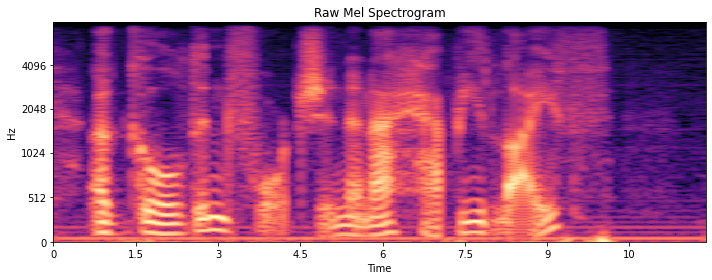

RuntimeError: ignored

In [132]:

# Step 0 : load audio file, extract mel spectrogram
audio, sampling_rate = librosa.load(audio_path)
mel_spectrogram = librosa.feature.melspectrogram(y=audio,sr=sampling_rate,n_mels=256,hop_length=128,fmax=8000)
                                                

# reshape spectrogram shape to [batch_size, time, frequency]
shape = mel_spectrogram.shape
mel_spectrogram = np.reshape(mel_spectrogram, (-1, shape[0], shape[1]))
mel_spectrogram = torch.from_numpy(mel_spectrogram)

# Show Raw mel-spectrogram
visualization_spectrogram(mel_spectrogram=mel_spectrogram,
                                                      title="Raw Mel Spectrogram")

# Calculate SpecAugment pytorch
warped_masked_spectrogram = spec_augment(mel_spectrogram=mel_spectrogram)

# Show time warped & masked spectrogram
visualization_spectrogram(mel_spectrogram=warped_masked_spectrogram,title="pytorch Warped & Masked Mel Spectrogram")
                                                      
